In [7]:
import numpy as np
from scipy.optimize import minimize
import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
from loguru import logger
from datetime import date
import datetime
plt.style.use('ggplot')

In [30]:
data1 = pd.read_pickle("data/BTC-28OCT22.pkl")
# data2 = pd.read_pickle("data/BTC-28OCT22.pkl")
# data2 = pd.read_pickle("data/BTC-25NOV22.pkl")
data2 = pd.read_pickle("data/BTC-30DEC22.pkl")

In [59]:
class SABR:
    def __init__(self, data: pd.DataFrame)->None:
        """Class to model the volatility smile"""
        self.data = data
        
        # let it be fixed as in the artice
        self.beta = 0.5
        
        #count in years as expiration date minus current date
        self.T = self.get_normal_date()
        
        # start params for optimization
        self.x0 = np.array([0.01, 0.00, 0.10])
        self.bounds = [(0.0001, 1000.0), (-0.9999, 0.9999), (0.0001, 1000)]
#         self.bounds = [(0.0001, 1), (-np.inf, np.inf), (0.00001, np.inf)]
#         self.bounds = [(None, None), (None, None), (None, None)]
        
    def get_normal_date(self):
        """Function to convert date to find years to maturity"""
        s = self.data.iloc[0].instrument_name
        monthToNum = {
            'JAN': 1,
            'FEB': 2,
            'MAR': 3,
            'APR': 4,
            'MAY': 5,
            'JUN': 6,
            'JUL': 7,
            'AUG': 8,
            'SEP': 9, 
            'OCT': 10,
            'NOV': 11,
            'DEC': 12
        }

        full_date = s.split("-")[1]
        day = int(full_date[:2])
        month = monthToNum[full_date[2:5]]
        year = int("20" + full_date[-2:])
        exp_date = date(year, month, day)
        res = abs(exp_date - datetime.datetime.today().date()).days/365
        logger.info(f"Year to maturity: {res}")
        return res    
    
    def _sigmaB(self, f: float, K: float, T: float, alpha: float, rho: float, v: float)->float:
        """Function to count modeled volatility"""
        first_part_of_numerator = (1 - self.beta)**2/24 * alpha**2/(f*K)**(1-self.beta)
        second_part_of_numerator = (rho*self.beta*v*alpha)/4*(f*K)**((1-self.beta)/2)
        third_part_of_numerator = (2 - 3*rho**2)*v**2/24
        numerator = alpha*(1 + self.T*(first_part_of_numerator + 
                                  second_part_of_numerator+ third_part_of_numerator))

        first_part_of_denominator = (1-self.beta)**2/24 * np.log(f/K)**2
        second_part_of_denominator = (1-self.beta)**4/1920 * np.log(f/K)**4
        denominator = (f*K)**((1-self.beta)/2)*(1 + first_part_of_denominator + second_part_of_denominator)

        z = v/alpha*(f*K)**((1-self.beta)/2)*np.log(f/K)

        xi = np.log((np.sqrt(1 - 2*rho*z + z**2)+z-rho)/(1-rho))

        return numerator/denominator * z/xi
    
    def _plot_results(self)->None:
        """Function to plot results"""
        def get_sigmas_for_set_of_params(alpha: float, rho: float, v: float)->None:
            """Inner function to count sigmas for current optimization method"""
            volatilities = []
            for index, row in self.data.iterrows():
                sigma_modeled = self._sigmaB(row.underlying_price, row.strike, self.T, alpha, rho, v)
                volatilities.append(sigma_modeled)
            return volatilities
            
        self.data["scipy_sigmas"] = get_sigmas_for_set_of_params(self.alpha_scipy, self.rho_scipy, self.v_scipy)
        self.data["own_sigmas"] = get_sigmas_for_set_of_params(self.alpha_own, self.rho_own, self.v_own)
                                                                 
        # build market volatilities
        
        fig, ax = plt.subplots(figsize=(15, 7))
        ax = sns.lineplot(x='strike', y='scipy_sigmas', data=self.data, label = "scipy optimizer")
        ax1 = sns.lineplot(x='strike', y='own_sigmas', data=self.data, label = "own optimizer")
        ax2 = sns.scatterplot(x='strike', y='mark_iv', data=self.data, label= 'market volatilities', color = "black").set_title("SABR model with different optimizers")

        
    def _vol_square_error(self, x: np.ndarray)->np.float64:
        """Function to get the argmin function we want to optimize"""
        # init market volatiliteis
        smile = self.data.mark_iv.to_numpy()
        vols = []
        for index, row in self.data.iterrows():
            vols.append(self._sigmaB(row["underlying_price"], row["strike"], self.T, x[0], x[1], x[2]))
        return sum((vols - smile)**2)
    
    def _own_minimizer(self):
        """The author completely understands the suboptimality, 
        but the author does not know how to count gradients for such giant function ): """
        min_values = (0, 0, 0)
        minimal = np.inf
        alpha_array = np.linspace(self.bounds[0][0], self.bounds[0][1], 10)
        rho_array = np.linspace(self.bounds[1][0], self.bounds[1][1], 10)
        v_array = np.linspace(self.bounds[2][0], self.bounds[2][1], 10)
        for alpha in alpha_array:
            for rho in rho_array:
                for v in v_array:
                    f_value = self._vol_square_error((alpha, rho, v))
                    if  f_value < minimal:
                        minimal = f_value
                        min_values = (alpha, rho, v)
#         print(minimal, min_values)
        return min_values
    
    def _minimize_scipy(self)->np.float64:
        """Optimization with scipy optimizer"""
        return minimize(self._vol_square_error, x0 = self.x0,  bounds = self.bounds)
    
    def run(self)->None:
        """Run optimization and plot results"""
        # optimization via scipy
        optimum_scipy  = self._minimize_scipy()
        self.alpha_scipy, self.rho_scipy, self.v_scipy = optimum_scipy.x
        logger.info(f"Optimal params with SCIPY: alpha = {self.alpha_scipy}, rho = {self.rho_scipy}, v = {self.v_scipy}")
        
        self.alpha_own, self.rho_own, self.v_own = self._own_minimizer()
        logger.info(f"Optimal params with OWN: alpha = {self.alpha_own}, rho = {self.rho_own}, v = {self.v_own}")
        #optimization via my own optimizer
        
        
        #plot market values and modeled function
        self._plot_results()
    

        
    

2022-10-24 14:44:12.283 | INFO     | __main__:get_normal_date:42 - Year to maturity: 0.010958904109589041
2022-10-24 14:44:12.503 | INFO     | __main__:run:120 - Optimal params with SCIPY: alpha = 348.91815706224867, rho = -0.002009087725282988, v = 192.54309909518082
2022-10-24 14:44:12.967 | INFO     | __main__:run:123 - Optimal params with OWN: alpha = 0.0001, rho = -0.33329999999999993, v = 222.22230000000002


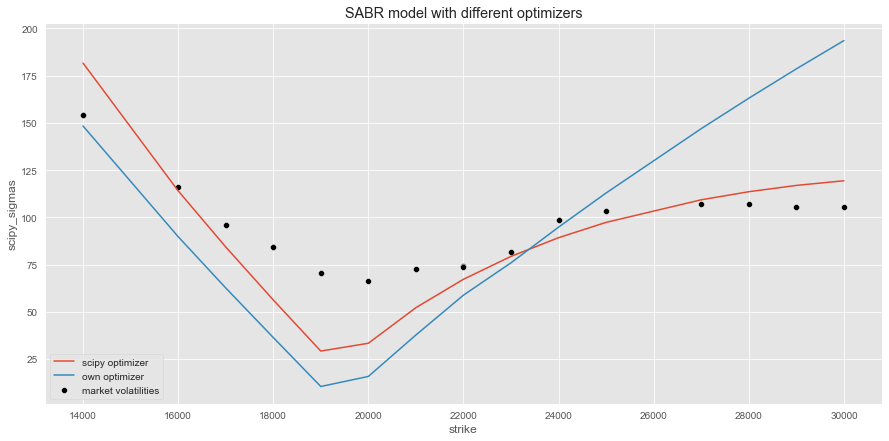

In [60]:
sabr = SABR(data1[data1["strike"]<=30000])
sabr.run()

2022-10-24 14:39:07.583 | INFO     | __main__:get_normal_date:41 - Year to maturity: 0.18356164383561643
2022-10-24 14:39:07.632 | INFO     | __main__:run:119 - Optimal params with SCIPY: alpha = 0.010000000000000049, rho = 4.9026297643359185e-18, v = 0.1000000000000016
2022-10-24 14:39:07.954 | INFO     | __main__:run:122 - Optimal params with OWN: alpha = 10.0, rho = 0.9999, v = 0.0001


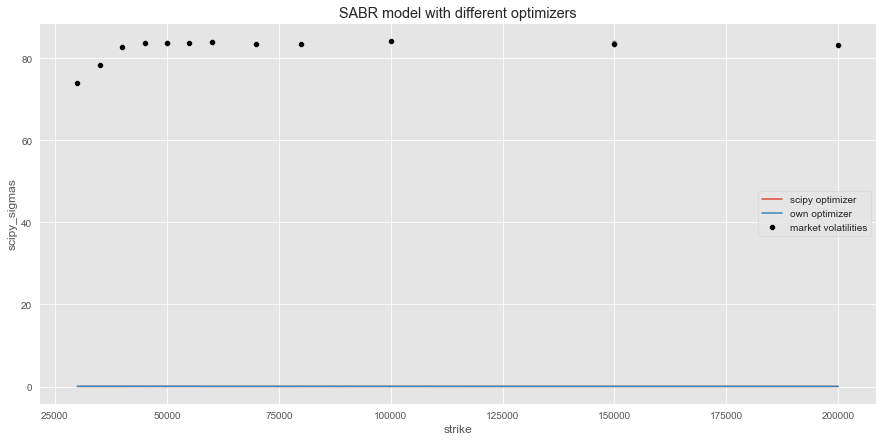

In [40]:
sabr = SABR(data2[data2["strike"]>=30000])
sabr.run()

2022-10-24 14:09:56.953 | INFO     | __main__:get_normal_date:41 - Year to maturity: 0.08767123287671233
2022-10-24 14:09:57.027 | INFO     | __main__:run:119 - Optimal params with SCIPY: alpha = 0.34554090635005574, rho = -0.31565335432604763, v = 33.95912782411756
2022-10-24 14:09:57.734 | INFO     | __main__:run:122 - Optimal params with OWN: alpha = 0.6667000000000001, rho = -0.33329999999999993, v = 100.0


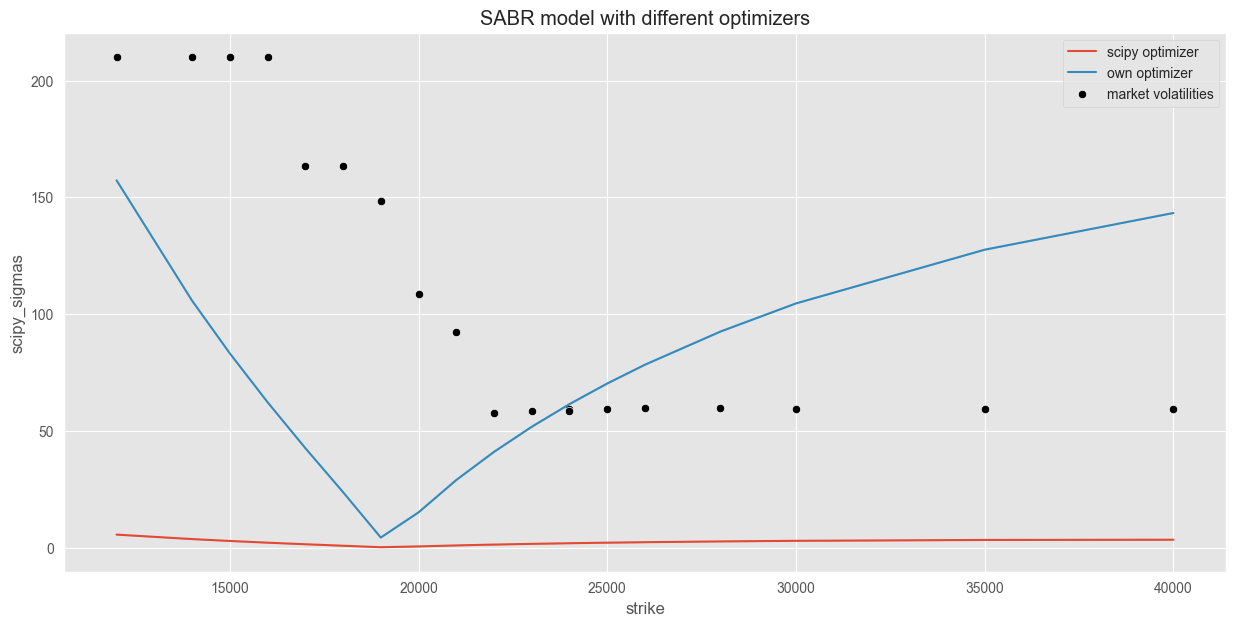

In [6]:
sabr = SABR(data3)
sabr.run()

2022-10-24 14:09:58.102 | INFO     | __main__:get_normal_date:41 - Year to maturity: 0.18356164383561643
2022-10-24 14:09:58.283 | INFO     | __main__:run:119 - Optimal params with SCIPY: alpha = 0.2865488984665962, rho = 0.27806082140229643, v = 30.064726826645963
2022-10-24 14:09:59.128 | INFO     | __main__:run:122 - Optimal params with OWN: alpha = 0.2223, rho = -0.5555, v = 88.8889


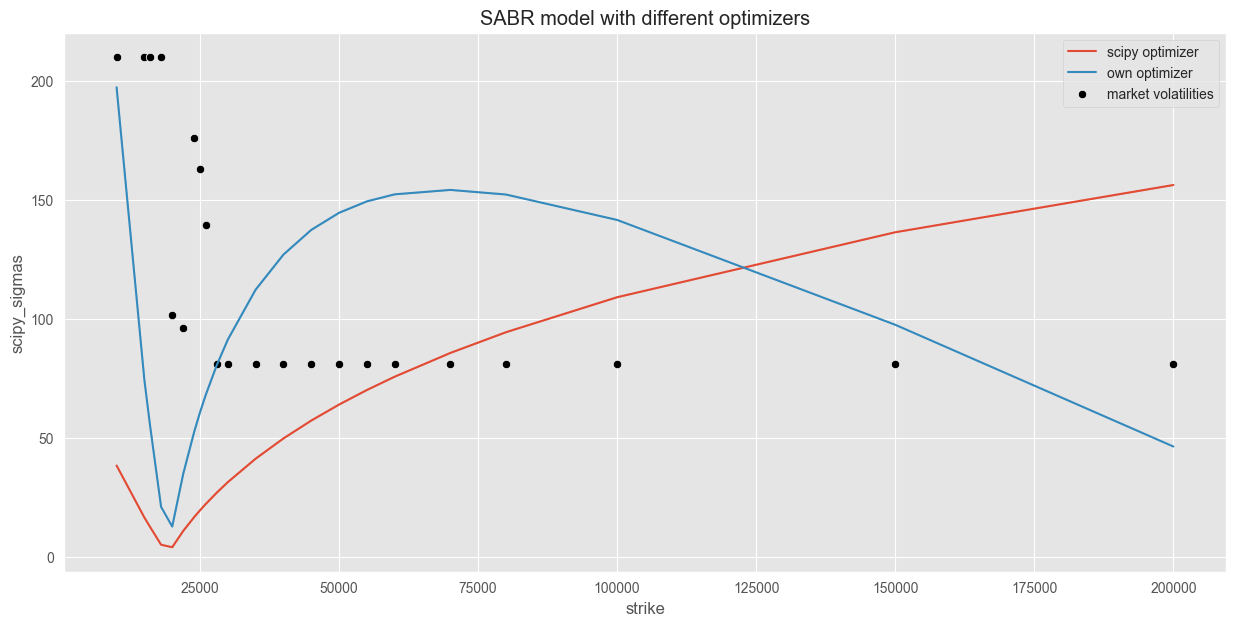

In [7]:
sabr = SABR(data4)
sabr.run()